# DTW applied to test dataset
In this notebook we are going to test how Dynamic Time Warping (DTW) performs in the test dataset.

## 1. Load data

In [5]:
import pickle
with open(f"../../data/1188_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
meta_obs = data['meta']
data_obs = data['data']
print(len(meta_obs), len(data_obs))

1188 1188


## 2. Calculate DTW distance - complete series
`dtw` does not look at time nor sampling rate, it assumes that the values are equally spread in the two time-series. This is going to be tricky to account for when comparing different time-series.
Also the distance given by `dtw` is not normalized, it would be still needed ot normalize by the path distances as:
```python
from tslearn.metrics import dtw_path

path, dist = dtw_path(x, y)
normalized_dist = dist / len(path)
```

In [3]:
import numpy as np
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt

/home/luisa/micromamba/envs/ts/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### 2.1 Distance between DINO-BRO pairs
We know this are 100% matches (i.e. the same time-series migrated from DINO -> BRO)

In [6]:
distance_bro_dino_pairs, norm_distance_bro_dino_pairs, gld_pairs = [], [], []
# Loop trough the data
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    bro_ts = data_obs[gld]['bro']
    if dino_ts.shape != bro_ts.shape:
        print(f"Shape mismatch for {gld}: dino {dino_ts.shape}, bro {bro_ts.shape}")
    if np.any(np.isnan(dino_ts)): 
        print(f"NaN values found for dino {gld} {dino_ts}")
        continue
    if np.any(np.isnan(bro_ts)): 
        print(f"NaN values found for bro {gld} {bro_ts}")
        continue
    if dino_ts.shape[0] < 2 or bro_ts.shape[0] < 2:
        print(f"Too few data points for {gld}: dino {dino_ts.shape}, bro {bro_ts.shape}")
        continue
    # time-series normalization
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    bro_ts[:, 1] = (bro_ts[:, 1] - np.mean(bro_ts[:, 1])) / np.std(bro_ts[:, 1])
    gld_pairs.append(gld)
    
    # raw DTW distance
    distance_bro_dino_pairs.append(dtw(dino_ts[:, 1], bro_ts[:, 1]))

    # normalized distance
    path, dist = dtw_path(dino_ts[:, 1], bro_ts[:, 1])
    norm_distance_bro_dino_pairs.append(dist / len(path))

In [4]:
len(distance_bro_dino_pairs)

1188

Statistics of DTW distances between bro and dino pairs:
Mean: 0.7146901688421731 ± Std: 1.0300351287539204
Median: 0.2051045400289494
Max: 6.679350266300475, Min: 0.0

Statistics of **normalized** DTW distances between bro and dino pairs:
Mean: 0.002040713211929276 ± Std: 0.0036422675622131656
Median: 0.0004755318991284326
Max: 0.03681681353047741, Min: 0.0


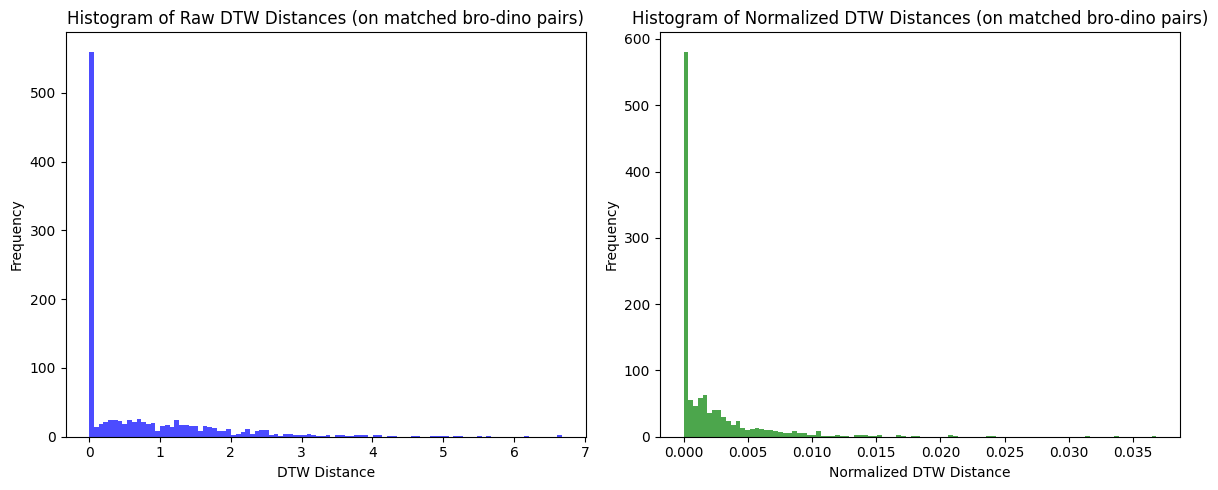

In [11]:
# Statistics
print(f"Statistics of DTW distances between bro and dino pairs:")
print(f"Mean: {np.mean(distance_bro_dino_pairs)} ± Std: {np.std(distance_bro_dino_pairs)}")
print(f"Median: {np.median(distance_bro_dino_pairs)}")
print(f"Max: {np.max(distance_bro_dino_pairs)}, Min: {np.min(distance_bro_dino_pairs)}")

print(f"\nStatistics of **normalized** DTW distances between bro and dino pairs:")
print(f"Mean: {np.mean(norm_distance_bro_dino_pairs)} ± Std: {np.std(norm_distance_bro_dino_pairs)}")
print(f"Median: {np.median(norm_distance_bro_dino_pairs)}")
print(f"Max: {np.max(norm_distance_bro_dino_pairs)}, Min: {np.min(norm_distance_bro_dino_pairs)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# Histogram for raw DTW distances
axes[0].hist(distance_bro_dino_pairs, bins=100, color='blue', alpha=0.7)
axes[0].set_xlabel("DTW Distance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of Raw DTW Distances (on matched bro-dino pairs)")

# Histogram for normalized DTW distances
axes[1].hist(norm_distance_bro_dino_pairs, bins=100, color='green', alpha=0.7)
axes[1].set_xlabel("Normalized DTW Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Normalized DTW Distances (on matched bro-dino pairs)")

plt.tight_layout()
plt.show()

We expected this distance to be 0 for most (if not all) of the data points, as during the preparation of `test_dataset` we skipped all records having different lengths.

Let's look at the time-series with the maximum distance:

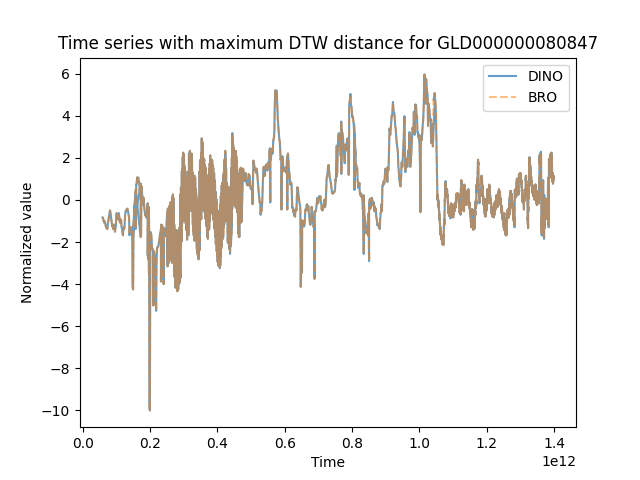

In [6]:
%matplotlib widget
# get id of the pair with the maximum distance
max_distance_index = np.argmax(distance_bro_dino_pairs)
gld_max_distance = gld_pairs[max_distance_index]
# plot the time series of the pair with the maximum distance
dino_max_DTW = data_obs[gld_max_distance]['dino']
bro_max_DTW = data_obs[gld_max_distance]['bro']
plt.figure()
plt.plot(dino_max_DTW[:, 0], dino_max_DTW[:, 1], label='DINO', alpha=0.7)
plt.plot(bro_max_DTW[:, 0], bro_max_DTW[:, 1], label='BRO', alpha=0.5, linestyle='--')
plt.xlabel("Time")
plt.ylabel("Normalized value")
plt.title(f"Time series with maximum DTW distance for {gld_max_distance}")
plt.legend()
plt.show()

There seem to be some non-reproducible errors when storing the data, characterized by some weird jumps in the dino series. Is rare, but sometimes happens. When querying the data using the same ID, the data looks good, no jumps.

### 2.2 Distance between two random time-series

In [8]:
import random
gld_1 = random.choice(list(data_obs.keys()))
gld_2 = random.choice(list(data_obs.keys()))
dino_ts = data_obs[gld_1]['dino'][:, 1]
bro_ts = data_obs[gld_2]['bro'][:, 1]
dino_ts = (dino_ts - np.mean(dino_ts)) / np.std(dino_ts)
bro_ts = (bro_ts - np.mean(bro_ts)) / np.std(bro_ts)
dtw_random = dtw(dino_ts, bro_ts)
path, dist = dtw_path(dino_ts, bro_ts)
print(f"DTW distance between random pair {gld_1} and {gld_2}: {dtw_random}")
print(f"Normalized DTW distance between random pair {gld_1} and {gld_2}: {dist / len(path)}")

DTW distance between random pair GLD000000058476 and GLD000000078298: 8.399463688791235
Normalized DTW distance between random pair GLD000000058476 and GLD000000078298: 0.035590947833861165


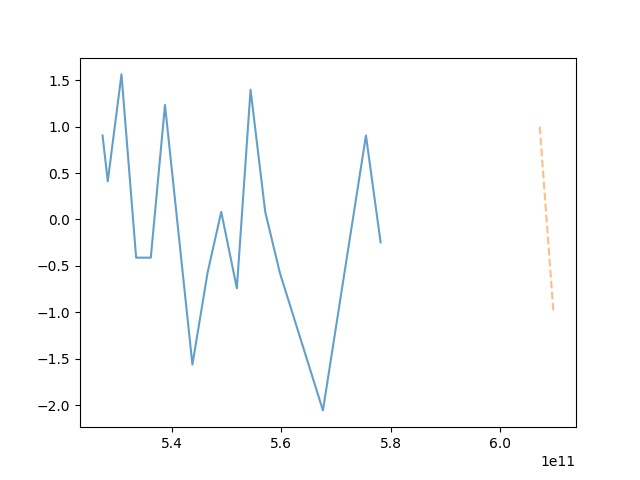

In [14]:
plt.figure()
plt.plot(data_obs[gld_1]['dino'][:, 0], data_obs[gld_1]['dino'][:, 1], label=f'DINO {gld_1}', alpha=0.7)
plt.plot(data_obs[gld_2]['bro'][:, 0], data_obs[gld_2]['bro'][:, 1], label=f'BRO {gld_2}', alpha=0.5, linestyle='--')

### 2.3 Statistics on non-matching sequences

In [9]:
distance_nonmatching, norm_distance_nonmatching, gld_pairs_nonmatching = [], [], []
max_pairs = 1000  # pick how many non-matching pairs you want
seen = set()
while len(gld_pairs_nonmatching) < max_pairs:
    g1, g2 = random.sample(list(data_obs.keys()), 2)  # ensures g1 != g2
    if (g1, g2) in seen:
        continue
    seen.add((g1, g2))
    dino_ts = data_obs[g1]['dino']
    bro_ts = data_obs[g2]['bro']
    # normalization
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    bro_ts[:, 1] = (bro_ts[:, 1] - np.mean(bro_ts[:, 1])) / np.std(bro_ts[:, 1])

    # DTW distance
    path, dist = dtw_path(dino_ts[:, 1], bro_ts[:, 1])
    distance_nonmatching.append(dist)
    norm_distance_nonmatching.append(dist / len(path))
    gld_pairs_nonmatching.append((g1, g2))

Statistics of DTW distances between non-matching bro and dino pairs:
Mean: 14.45169929619009 ± Std: 8.560931448431488
Median: 12.85186678213304
Max: 90.36594498684681, Min: 2.951160305694819

Statistics of **normalized** DTW distances between non-matching bro and dino pairs:
Mean: 0.036519556360604326 ± Std: 0.02304555485239647
Median: 0.03212827373020259
Max: 0.19371835015826228, Min: 0.00264929789931441


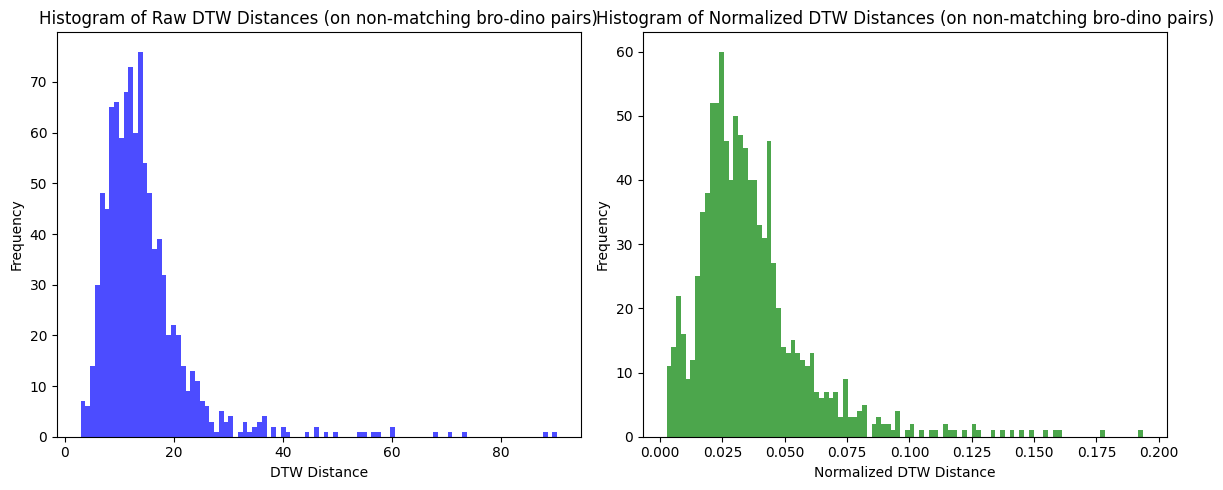

In [15]:
# Statistics
print(f"Statistics of DTW distances between non-matching bro and dino pairs:")
print(f"Mean: {np.mean(distance_nonmatching)} ± Std: {np.std(distance_nonmatching)}")
print(f"Median: {np.median(distance_nonmatching)}")
print(f"Max: {np.max(distance_nonmatching)}, Min: {np.min(distance_nonmatching)}")

print(f"\nStatistics of **normalized** DTW distances between non-matching bro and dino pairs:")
print(f"Mean: {np.mean(norm_distance_nonmatching)} ± Std: {np.std(norm_distance_nonmatching)}")
print(f"Median: {np.median(norm_distance_nonmatching)}")
print(f"Max: {np.max(norm_distance_nonmatching)}, Min: {np.min(norm_distance_nonmatching)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# Histogram for raw DTW distances
axes[0].hist(distance_nonmatching, bins=100, color='blue', alpha=0.7)
axes[0].set_xlabel("DTW Distance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of Raw DTW Distances (on non-matching bro-dino pairs)")

# Histogram for normalized DTW distances
axes[1].hist(norm_distance_nonmatching, bins=100, color='green', alpha=0.7)
axes[1].set_xlabel("Normalized DTW Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Normalized DTW Distances (on non-matching bro-dino pairs)")

plt.tight_layout()
plt.show()

## 3. DTW distance - subsequence
`tslearn` also allows to calculate the minimum similarity score between a subsequence and the full time sereis (i.e. template matching). This can be useful to search matches of partial data.

In [9]:
from tslearn.metrics import dtw_subsequence_path
d = data_obs[gld_1]['dino'][:, 1]
b = data_obs[gld_1]['bro'][:, 1]
d = (d - d.mean()) / d.std()
b = (b - b.mean()) / b.std()
path, dist = dtw_subsequence_path(d, b)
print(dist)

0.0
